# First Milestone Final Notebook 

In [43]:
import os
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from textblob import TextBlob
from nltk.corpus import stopwords
import re
import numpy as np

# Loading the data

In [9]:
files = os.listdir('./001_medium')
texts = []
countries = []
positions = []
titles = []

for i in range(len(files) ):
#     print(i[:2])
#     print(files[i])
#     print( i, (files[i].split('.')[0]).split('_')[-1])
    # Read the text
    f = open("./001_medium/"+files[i], "r",  encoding="ISO-8859-1" )
    s = f.read()
    texts.append(s.strip())
    # Read the country
    countries.append(files[i].split('_')[0])
    # Read the position
    positions.append( (files[i].split('.')[0]).split('_')[-1] )
    # Read the full title
    titles.append( files[i].split('.') )
#     titles.append(files[i])
f.close()

In [10]:
# Creating a dataframe
df = pd.DataFrame(list(zip(countries, positions, texts)),
               columns =['country', 'title', 'text'])
df.head()

,country,title,text
0,AT,Inform,https://www.linkedin.com/company/global-blue/l...
1,AT,Architect,https://www.linkedin.com/jobs/view/2589036509/...
2,AT,Manager,www.linkedin.com/jobs/view/2540581439/\n\nInfo...
3,CZ,IPSecu,https://www.linkedin.com/jobs/view/2410398234/...
4,CZ,Senior,https://www.linkedin.com/jobs/view/2487448959/...


### Now I will write dataframe to csv so we don't have read files everytime

In [11]:
df.to_csv('jobs.csv', index=False)
df = pd.read_csv('jobs.csv')

In [23]:
df = pd.read_csv('jobs.csv')

## Basic feature extraction

In [13]:
df['word_count'] = df['text'].apply(lambda x: len( x.strip(' ')))
df[[ 'text', 'word_count']].head()

,text,word_count
0,https://www.linkedin.com/company/global-blue/l...,10293
1,https://www.linkedin.com/jobs/view/2589036509/...,2861
2,www.linkedin.com/jobs/view/2540581439/\n\nInfo...,4849
3,https://www.linkedin.com/jobs/view/2410398234/...,2673
4,https://www.linkedin.com/jobs/view/2487448959/...,3394


In [16]:
# Stop words per row
stop = stopwords.words('english')
df['stopwords'] = df['text'].apply(lambda x: len([x for x in x.split() if x in stop]))
df.head()

,country,title,text,word_count,stopwords
0,AT,Inform,https://www.linkedin.com/company/global-blue/l...,10293,300
1,AT,Architect,https://www.linkedin.com/jobs/view/2589036509/...,2861,134
2,AT,Manager,www.linkedin.com/jobs/view/2540581439/\n\nInfo...,4849,199
3,CZ,IPSecu,https://www.linkedin.com/jobs/view/2410398234/...,2673,82
4,CZ,Senior,https://www.linkedin.com/jobs/view/2487448959/...,3394,105


## Cleaning the text column

In [25]:

# Removal of links
df['text'] = df['text'].apply(lambda x: re.sub(r'https?://\S+|www\.\S+', '', x))

# Extract Job Title from text
df['job_title'] = df['text'].apply(lambda x: (re.sub(r'^.*?\n', '\n', x).strip()).split('\n')[0] )

# Removal of punctuations
df['text'] = df['text'].str.replace('[^\w\s]','')

stop = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

df.head()

C:\Users\elsha\AppData\Local\Temp/ipykernel_11204/3961677791.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace('[^\w\s]','')


,country,title,text,job_title
0,AT,Inform,Information Technology Security Manager Global...,Information Technology Security Manager
1,AT,Architect,Information Security Architect Copmany SWAROVS...,Information Security Architect
2,AT,Manager,Information Technology Security Manager Copman...,Information Technology Security Manager
3,CZ,IPSecu,IP Security Architect About job Description Th...,IP Security Architect
4,CZ,Senior,Senior Information Security Analyst About job ...,Senior Information Security Analyst


#### Lets check how many roles we have for each position

In [29]:
df['job_title'].value_counts()

Security Engineer                                         7
Information Security Engineer                             4
Security Analyst                                          4
Cyber Security Consultant                                 2
Senior Security Researcher                                2
                                                         ..
Cyber Security Analyst at Honeywell                       1
System Engineer at SolarWinds                             1
Associate Offensive Security Engineer Managed Services    1
Senior Security Operations Engineer at Pure Storage       1
Incident Response Engineer                                1
Name: job_title, Length: 91, dtype: int64

Security Engineers come on top followed by Information Security Engineers

### Lemmatization

In [54]:
# Lemmatization
from textblob import Word
df['text'] = df['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
print(df['text'].head())

0    Information Technology Security Manager Global...
1    Information Security Architect Copmany SWAROVS...
2    Information Technology Security Manager Copman...
3    IP Security Architect About job Description Th...
4    Senior Information Security Analyst About job ...
Name: text, dtype: object


## Most frequent words

In [51]:
freq = pd.Series(' '.join(df['text']).split()).value_counts()[:20]
print(freq)

security       760
Security       387
team           248
experience     234
system         223
IT             215
Experience     181
work           164
skill          162
You            158
Information    152
information    132
management     132
network        127
knowledge      126
technology     124
solution       119
Job            109
technical      109
The            107
dtype: int64


### N Grams

In [50]:
print(TextBlob(df['text'][0]).ngrams(2)[:5])

[WordList(['Information', 'Technology']), WordList(['Technology', 'Security']), WordList(['Security', 'Manager']), WordList(['Manager', 'Global']), WordList(['Global', 'Blue'])]


## Applying TF IDF

In [37]:
tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word',
 stop_words= 'english',ngram_range=(1,1))

vect = tfidf.fit_transform(df['text'])

tf_df = pd.DataFrame(vect[1].T.todense(), index=tfidf.get_feature_names_out(), 
             columns=["TF-IDF"]).sort_values('TF-IDF', ascending=False)
tf_df.head()

,TF-IDF
information,0.397172
security,0.356113
program,0.298509
salary,0.217892
define,0.166721


## Find Cosine Similarity using Spacy

In [40]:
import en_core_web_md 

nlp = en_core_web_md.load()

C:\Users\elsha\anaconda3\lib\site-packages\spacy\util.py:833: UserWarning: [W095] Model 'en_core_web_md' (3.1.0) was trained with spaCy v3.1 and may not be 100% compatible with the current version (3.2.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [41]:
doc1 = nlp(df['text'][0])
doc2 = nlp(df['text'][1])

doc1.similarity(doc2) 

0.9871958346186012

### Below I built a sparse matrix which contains cosine similarites between job description

In [44]:
# Because of the run time I set N to 5. When N is 110 it takes few minutes to run. I did run it once and saved it to csv 
# N = (len(df['text']))
N = 5
matrix = np.zeros(( N, N))
for i in range(N):
    for j in range(N):
        matrix[i][j] = nlp(df['text'][i]).similarity( nlp(df['text'][j] ) )

sp_df = pd.DataFrame(matrix)

sp_df.columns = list(df['job_title'])[:N]
sp_df.index = list(df['job_title'])[:N]

In [45]:
sp_df.head()

,Information Technology Security Manager,Information Security Architect,Information Technology Security Manager,IP Security Architect,Senior Information Security Analyst
Information Technology Security Manager,1.000000,0.987196,0.989958,0.908403,0.968996
Information Security Architect,0.987196,1.000000,0.987307,0.912618,0.977619
Information Technology Security Manager,0.989958,0.987307,1.000000,0.915909,0.981832
IP Security Architect,0.908403,0.912618,0.915909,1.000000,0.916763
Senior Information Security Analyst,0.968996,0.977619,0.981832,0.916763,1.000000


In [47]:
import seaborn as sns

<AxesSubplot:>

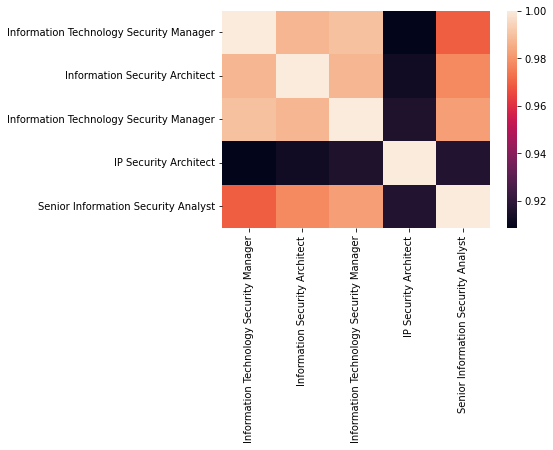

In [48]:
sns.heatmap(sp_df)

<h3> <center> ** Coming Soon ** </center></h3>
<h1> <center> Investigating the sparse matrix </center>  </h1>